#### Real Estate Room Type Classification on Redfin Data

Here, we intend to build a real estate classification model similar to one build by cohort 13. The aim is to classify the room images into 7 base classes - kitchen, bathroom, bedroom, dining_room, living_room, Exterior and Interior. 
We use the unlabelled dataset collected by previous team from redfin website. The data was stored in terms of 19 batch wise folders, where each folder contained 1000 listings and each listings contained ~20 images.

For the purpose of labelling, we run prediction using pre-trained model on set of 20000 images of any one batch. We visually correct labeling for half of data. Except Interior, other classes are easily identifiable. We classify Interior rooms as the ones which have features such as - attic, washer_dryer room,  study tables, children room, staircases, entrances, foyers,etc.
In cases where images have no furnitures, we choose interior as one which is not visually identifiable into other categories, like images with windows or rooms with sloped ceiling

Additionally, we use annoy to label data. This is done by finding similar images from unlabelled sample for a given sample of train images. We then use the label of train image in order to label test images.

The train data was laballed from one batch and for validation we use data from another batch. This way, We were able to gather 3000 labelled images. We have trained model on top of pretrained model of previous cohort. With this, we could reach ~85% accuracy, although more work needs to be done.

**Import Libraries**

In [415]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *
import matplotlib.pyplot as plt
import seaborn as sns

**Getting the data**

In [450]:
PATH = Path('batch_images/')
PATH

PosixPath('batch_images')

In [451]:
train_df = pd.read_excel('train_5.xlsx')
train_df.drop(columns = ['predicted_labels','Unnamed: 3'],axis = 1, inplace=True)
train_df.dropna(thresh=2, inplace=True)
train_df['valid'] = False
train_df.head(), train_df.shape

(       image_path correct_labels  valid
 0   5_/5000/0.jpg       Exterior  False
 1   5_/5000/1.jpg        kitchen  False
 2  5_/5000/10.jpg       Exterior  False
 3  5_/5000/11.jpg       Exterior  False
 4  5_/5000/12.jpg       Exterior  False, (2711, 3))

In [452]:
partial_df = pd.read_csv('partial.csv')

In [453]:
partial_df.drop(columns = ['Unnamed: 0'],axis = 1, inplace=True)
partial_df['valid'] = False
partial_df.head()

,image_path,correct_labels,valid
0,5_/5075/26.jpg,bathroom,False
1,5_/5075/7.jpg,dining_room,False
2,5_/5076/2.jpg,Exterior,False
3,5_/5076/22.jpg,Exterior,False
4,5_/5076/7.jpg,living_room,False


In [455]:
partial_df.shape

(518, 3)

In [457]:
train_df = train_df.append(partial_df)

In [458]:
valid_df = pd.read_excel('valid.xlsx')
valid_df.drop(columns = ['predicted_labels'],axis = 1, inplace=True)
valid_df.dropna(thresh=2, inplace=True)
valid_df['valid'] = True
valid_df.head(), valid_df.shape

(       image_path correct_labels  valid
 0   7_/7000/0.jpg       Exterior   True
 1   7_/7000/1.jpg       Exterior   True
 2  7_/7000/10.jpg        kitchen   True
 3  7_/7000/11.jpg        kitchen   True
 4  7_/7000/12.jpg       Interior   True, (221, 3))

In [459]:
df = train_df.append(valid_df)

In [461]:
df.shape

(3450, 3)

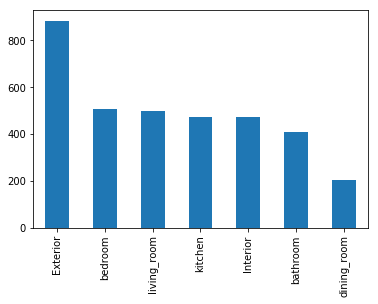

In [462]:
pd.value_counts(df['correct_labels']).plot.bar()

In [464]:
np.random.seed(42)
data = (ImageList.from_df(df,PATH).split_from_df(col='valid')
       .label_from_df().transform(get_transforms(do_flip=False),size=224)
        .databunch(bs=8).normalize(imagenet_stats))

In [466]:
# number of classes
print(f'Dataset has {data.c} classes: {data.classes}')

Dataset has 7 classes: ['Exterior', 'Interior', 'bathroom', 'bedroom', 'dining_room', 'kitchen', 'living_room']


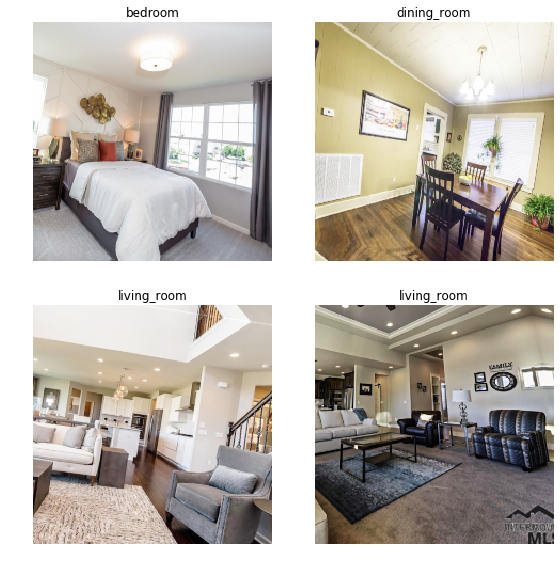

In [467]:
data.show_batch(rows=2)

**Training the model**

We first train only last few layers and later unfreeze and train the whole network

In [471]:
Path('models').absolute()

PosixPath('/home/fellowship_ai/models')

In [472]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy,model_dir = Path('models').absolute()).load('realestate-classification-rn50')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


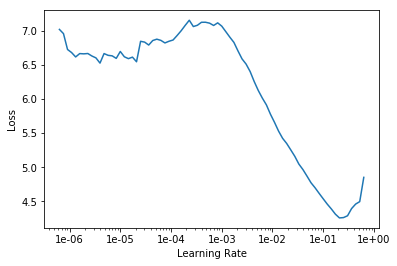

In [473]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,1.890594,0.974101,0.674208,02:46
1,0.627726,0.424375,0.855204,02:28
2,0.571320,0.391306,0.850679,02:29
3,0.497465,0.403443,0.855204,02:29
4,0.481890,0.386294,0.859729,02:29
5,0.464631,0.407907,0.846154,02:29


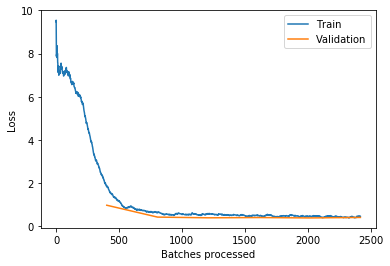

In [474]:
learn.fit_one_cycle(6,max_lr=slice(1e-03))
learn.recorder.plot_losses()

In [476]:
learn.save('3000-redfin-stage-1')

In [477]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


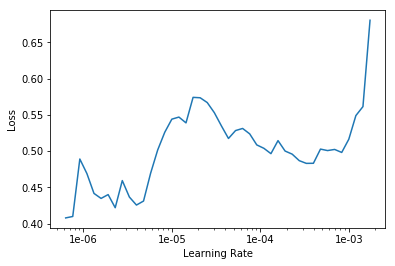

In [478]:
learn.lr_find()
learn.recorder.plot()

In [479]:
learn.fit_one_cycle(4, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.836236,1.011480,0.728507,02:32
1,0.872482,0.538859,0.859729,02:33
2,0.607562,0.436455,0.868778,02:32
3,0.408245,0.406410,0.868778,02:33


In [480]:
learn.save('3000-redfin-stage-2')

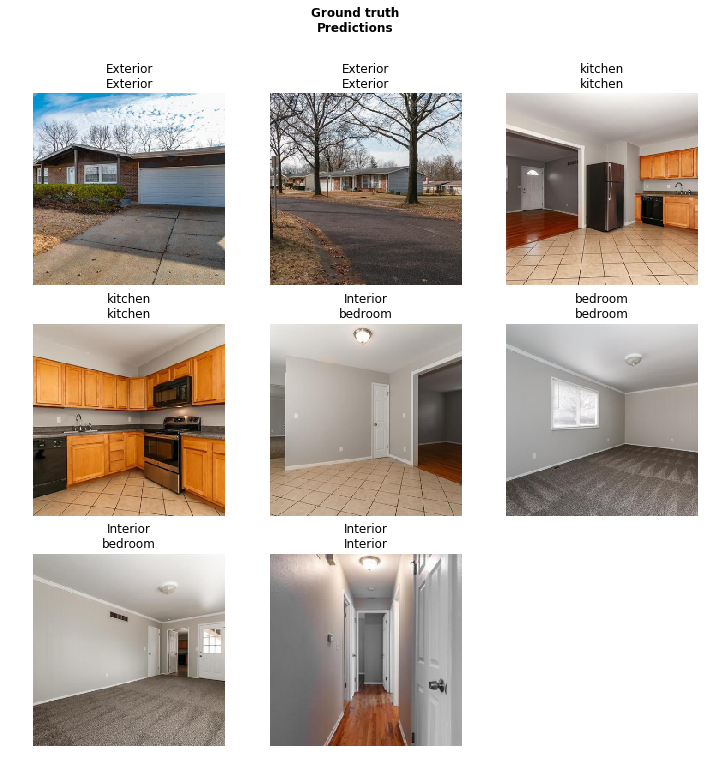

In [481]:
learn.show_results()

In [482]:
interp = ClassificationInterpretation.from_learner(learn)

In [483]:
interp.most_confused()

[('bedroom', 'Interior', 4),
 ('living_room', 'bedroom', 4),
 ('Interior', 'bedroom', 3),
 ('living_room', 'Interior', 3),
 ('Exterior', 'Interior', 2),
 ('bathroom', 'Interior', 2),
 ('living_room', 'kitchen', 2),
 ('Interior', 'bathroom', 1),
 ('Interior', 'living_room', 1),
 ('bathroom', 'dining_room', 1),
 ('bedroom', 'bathroom', 1),
 ('bedroom', 'kitchen', 1),
 ('bedroom', 'living_room', 1),
 ('dining_room', 'kitchen', 1),
 ('kitchen', 'Interior', 1),
 ('kitchen', 'dining_room', 1)]

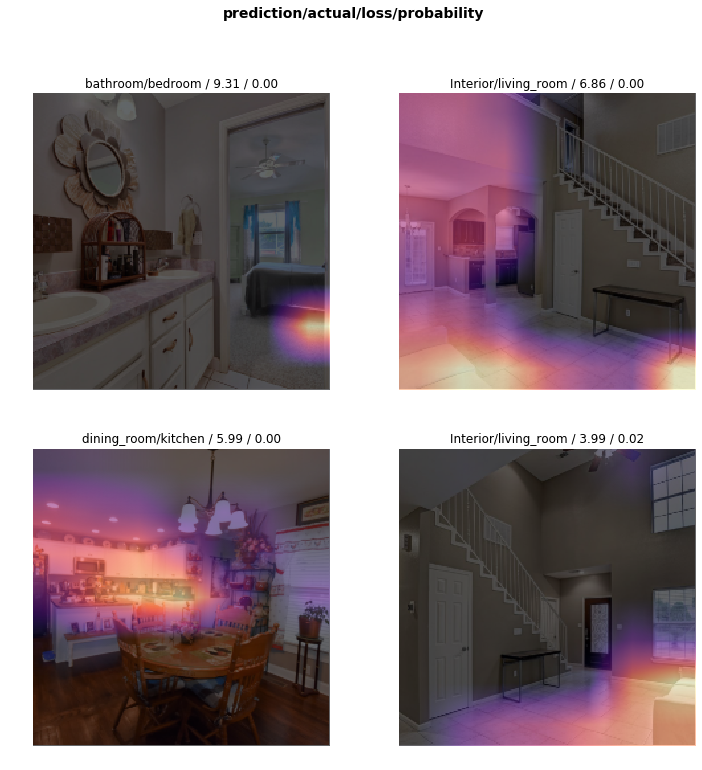

In [484]:
interp.plot_top_losses(4)

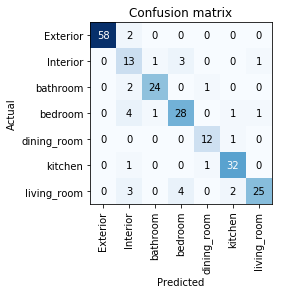

In [485]:
interp.plot_confusion_matrix()

**Key Observations**

1. From the most confused output, we see that interior and bedroom gets confused a lot. We believe, this is mainly in cases where rooms are empty, few rooms were labelled as interior and few of them where labelled as bedrooms. Since the rooms are mainly empty, there isnt any main distinguishing feature between the 2 classes. The same would be the case for living room and interior comparision
2. From losses plot, i see that train and validation loss seems to settle down. At the end, validation loss seems to increase, implying overfitting. I believe training on more data alongwith augmentation should give us better results
3. Additionally, from top losses plot, looks like there is issue in the labeled data causing incorrect classification and this would have to be manually corrected